In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import pyarrow


csv_path = "F:/Google DOwnloads/rximage/table.csv"
df = pd.read_csv(csv_path)

processed_rows = []

for _, row in df.iterrows():
    img_path = f"F:/Google DOwnloads/rximage/{row['RXNAV ORIGINAL']}"
    if not os.path.exists(img_path):
        continue
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    flat = img.flatten()
    processed_row = {
        'name': row['name'],
        **{f'feat_{i}': flat[i] for i in range(len(flat))}
    }
    processed_rows.append(processed_row)

# Spark timing out so saving to parquet and feeding to Spark
out_df = pd.DataFrame(processed_rows)
out_df.to_parquet("F:/Google DOwnloads/rximage/processed.parquet")


## Third attempt at prepreprocessing and currently 123 minutes in. Do not believe it will complete on time.


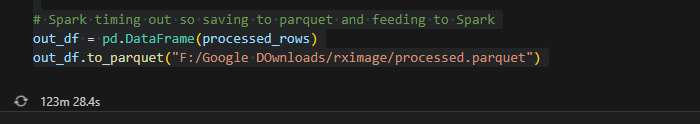




In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder \
    .appName("RxImageClassification") \
    .master("local[*]") \
    .getOrCreate()

spark_df = spark.read.parquet("F:/Google DOwnloads/rximage/processed.parquet")

indexer = StringIndexer(inputCol="name", outputCol="label")

feature_cols = [col for col in spark_df.columns if col.startswith('feat_')]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20)

pipeline = Pipeline(stages=[indexer, assembler, rf])

train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

predictions.select("name", "label", "prediction").show(10)